In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
#定義類別與其整數對應

class_mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}

In [3]:
#讀取每張圖片，與其標籤
# OpenCV 本身就有提供讀取圖片檔的函數可用，讀取一般的圖片檔，只要呼叫 cv2.imread 即可將圖片讀取進來
# 以 cv2.imread 讀進來的資料，會儲存成一個 NumPy 的陣列

#  在OpenCV中，图像不是用常规的RGB颜色通道来存储的，它们用的是BGR顺序。当读取一幅图像后，
#  默认的是BGR，不过有很多转换方式是可以利用的。颜色空间转换可以用函数cvtColor()函数

# # 使用 OpenCV 讀取圖檔
# img_bgr = cv2.imread('image.jpg')

# # 將 BGR 圖片轉為 RGB 圖片
# img_rgb = img_bgr[:,:,::-1]

# # 或是這樣亦可
# # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# # 使用 Matplotlib 顯示圖片
# plt.imshow(img_rgb)
# plt.show()


img_paths = glob.glob('/home/jovyan/Midterm_DL/train/*/*.jpg')
images, labels = [], []
img_sizes = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)
    label = img_path.split('/')[-2]
    label = class_mapping.get(label)
    images.append(img)
    labels.append(label)
images = np.array(images)
labels = np.uint8(labels)

In [4]:
images.shape

(588, 299, 299, 3)

In [5]:
x_Train4D = images.reshape(images.shape[0],299, 299,3).astype('float32') 
x_Train4D.shape

(588, 299, 299, 3)

In [6]:
x_Train4D_normalize = x_Train4D/255

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train_1, y_valid_1 = train_test_split(x_Train4D_normalize, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    )

In [8]:
y_train = np_utils.to_categorical(y_train_1)
y_valid = np_utils.to_categorical(y_valid_1)

In [9]:
X_train.shape

(470, 299, 299, 3)

In [10]:
y_train.shape

(470, 10)

In [11]:
X_valid.shape

(118, 299, 299, 3)

In [12]:
y_valid.shape

(118, 10)

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
model_name = 'Xception-Fine-Tune'
num_classes = 10

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

epochs = 10
batch_size = 10

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/10
46/47 [============================>.] - ETA: 0s - loss: 2.3279 - accuracy: 0.1283
Epoch 00001: val_loss improved from inf to 2.26287, saving model to ./saved_models/Xception-Fine-Tune.h5
47/47 [==============================] - 21s 437ms/step - loss: 2.3263 - accuracy: 0.1298 - val_loss: 2.2629 - val_accuracy: 0.1186
Epoch 2/10
46/47 [============================>.] - ETA: 0s - loss: 2.2686 - accuracy: 0.1391
Epoch 00002: val_loss improved from 2.26287 to 2.19216, saving model to ./saved_models/Xception-Fine-Tune.h5
47/47 [==============================] - 18s 387ms/step - loss: 2.2669 - accuracy: 0.1383 - val_loss: 2.1922 - val_accuracy: 0.2542
Epoch 3/10
46/47 [============================>.] - ETA: 0s - loss: 2.1481 - accuracy: 0.2522
Epoch 00003: val_loss improved from 2.19216 to 2.11330, saving model to ./saved_models/Xception-Fine-Tune.h5
47/47 [==============================] - 19s 406ms/step - loss: 2.1474 - accuracy: 0.2511 - val_loss: 2.1133 - val_accuracy: 0.3983

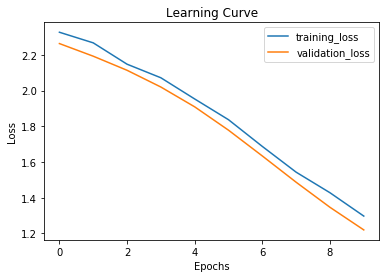

In [16]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

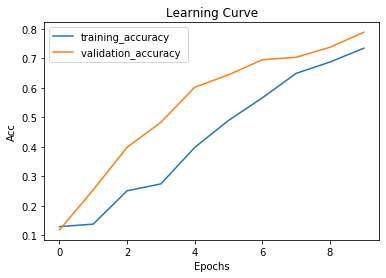

In [17]:
training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# Vilidation Set 預測錯誤分析

In [18]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

118/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
X_valid_prediction = model.predict(X_valid)
prediction_X_valid = X_valid_prediction.argmax(axis=-1)

In [20]:
prediction_X_valid

array([5, 2, 9, 9, 1, 7, 8, 8, 9, 7, 9, 1, 9, 0, 6, 1, 0, 0, 5, 6, 2, 3,
       5, 3, 9, 3, 2, 8, 9, 8, 0, 6, 1, 4, 2, 3, 0, 9, 9, 5, 0, 7, 3, 9,
       1, 3, 0, 1, 3, 6, 9, 9, 0, 7, 1, 7, 3, 9, 2, 6, 5, 7, 5, 9, 2, 6,
       5, 5, 2, 0, 3, 7, 6, 9, 3, 0, 3, 3, 4, 3, 7, 6, 9, 6, 0, 7, 5, 3,
       6, 0, 6, 5, 7, 7, 0, 1, 3, 8, 3, 4, 6, 0, 3, 0, 4, 8, 0, 5, 2, 1,
       6, 1, 5, 3, 6, 2, 5, 6])

In [21]:
import pandas as pd
pd.crosstab(y_valid_1,prediction_X_valid, rownames=['label'],colnames=['predict'])

predict   0  1  2   3  4   5   6  7  8   9
label                                     
0        12  0  0   0  0   0   0  0  0   3
1         1  9  0   0  0   2   0  0  0   0
2         0  0  8   0  0   0   0  0  0   0
3         1  1  0  15  0   0   0  1  0   0
4         0  0  0   3  4   0   0  4  0   2
5         0  0  0   0  0  10   0  0  0   0
6         2  0  0   0  0   1  14  0  0   0
7         0  0  0   0  0   0   0  4  0   0
8         0  0  1   0  0   0   1  2  6   0
9         0  0  0   0  0   0   0  0  0  11

In [22]:
df = pd.DataFrame({'label':y_valid_1 , 'predict':prediction_X_valid})

In [23]:
class_mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}
inv_mapping = {v: k for k , v in class_mapping.items()}
inv_mapping

{0: '18',
 1: 'Ellie',
 2: 'Prof.Kang',
 3: 'Rockman',
 4: 'Yoshit',
 5: 'lala',
 6: 'tan',
 7: 'tim',
 8: 'wwk',
 9: 'Jerry'}

In [24]:
label_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['label'][i]]
    label_1.append(aa)  

In [25]:
label_1 = pd.DataFrame(label_1 , columns = ['label_1'])
df = pd.concat([df , label_1] , axis=1)
df

label  predict    label_1
0        5        5       lala
1        2        2  Prof.Kang
2        4        9     Yoshit
3        0        9         18
4        1        1      Ellie
..     ...      ...        ...
113      3        3    Rockman
114      6        6        tan
115      2        2  Prof.Kang
116      1        5      Ellie
117      6        6        tan

[118 rows x 3 columns]

In [26]:
predict_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['predict'][i]]
    predict_1.append(aa)  

In [27]:
predict_1 = pd.DataFrame(predict_1 , columns = ['predict_1'])
df = pd.concat([df , predict_1] , axis=1)
df

label  predict    label_1  predict_1
0        5        5       lala       lala
1        2        2  Prof.Kang  Prof.Kang
2        4        9     Yoshit      Jerry
3        0        9         18      Jerry
4        1        1      Ellie      Ellie
..     ...      ...        ...        ...
113      3        3    Rockman    Rockman
114      6        6        tan        tan
115      2        2  Prof.Kang  Prof.Kang
116      1        5      Ellie       lala
117      6        6        tan        tan

[118 rows x 4 columns]

In [28]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict    18  Ellie  Jerry  Prof.Kang  Rockman  Yoshit  lala  tan  tim  wwk
label                                                                       
18         12      0      3          0        0       0     0    0    0    0
Ellie       1      9      0          0        0       0     2    0    0    0
Jerry       0      0     11          0        0       0     0    0    0    0
Prof.Kang   0      0      0          8        0       0     0    0    0    0
Rockman     1      1      0          0       15       0     0    0    1    0
Yoshit      0      0      2          0        3       4     0    0    4    0
lala        0      0      0          0        0       0    10    0    0    0
tan         2      0      0          0        0       0     1   14    0    0
tim         0      0      0          0        0       0     0    0    4    0
wwk         0      0      0          1        0       0     0    1    2    6

In [29]:
df_wrong = df[df.label_1!=df.predict_1]
df_wrong 

label  predict  label_1  predict_1
2        4        9   Yoshit      Jerry
3        0        9       18      Jerry
5        4        7   Yoshit        tim
24       0        9       18      Jerry
34       8        2      wwk  Prof.Kang
36       1        0    Ellie         18
42       4        3   Yoshit    Rockman
43       0        9       18      Jerry
52       6        0      tan         18
53       3        7  Rockman        tim
54       3        1  Rockman      Ellie
60       1        5    Ellie       lala
63       4        9   Yoshit      Jerry
71       4        7   Yoshit        tim
79       4        3   Yoshit    Rockman
80       4        7   Yoshit        tim
84       6        0      tan         18
85       4        7   Yoshit        tim
86       6        5      tan       lala
89       3        0  Rockman         18
90       8        6      wwk        tan
92       8        7      wwk        tim
93       8        7      wwk        tim
98       4        3   Yoshit    Rockman
116      1        5    Ellie       lala

In [30]:
wrongindex = df_wrong.index
wrongindex

Int64Index([  2,   3,   5,  24,  34,  36,  42,  43,  52,  53,  54,  60,  63,
             71,  79,  80,  84,  85,  86,  89,  90,  92,  93,  98, 116],
           dtype='int64')

In [31]:
df_wrong['label_1'].iloc[1] , df_wrong['predict_1'].iloc[1] , wrongindex[1]

('18', 'Jerry', 3)

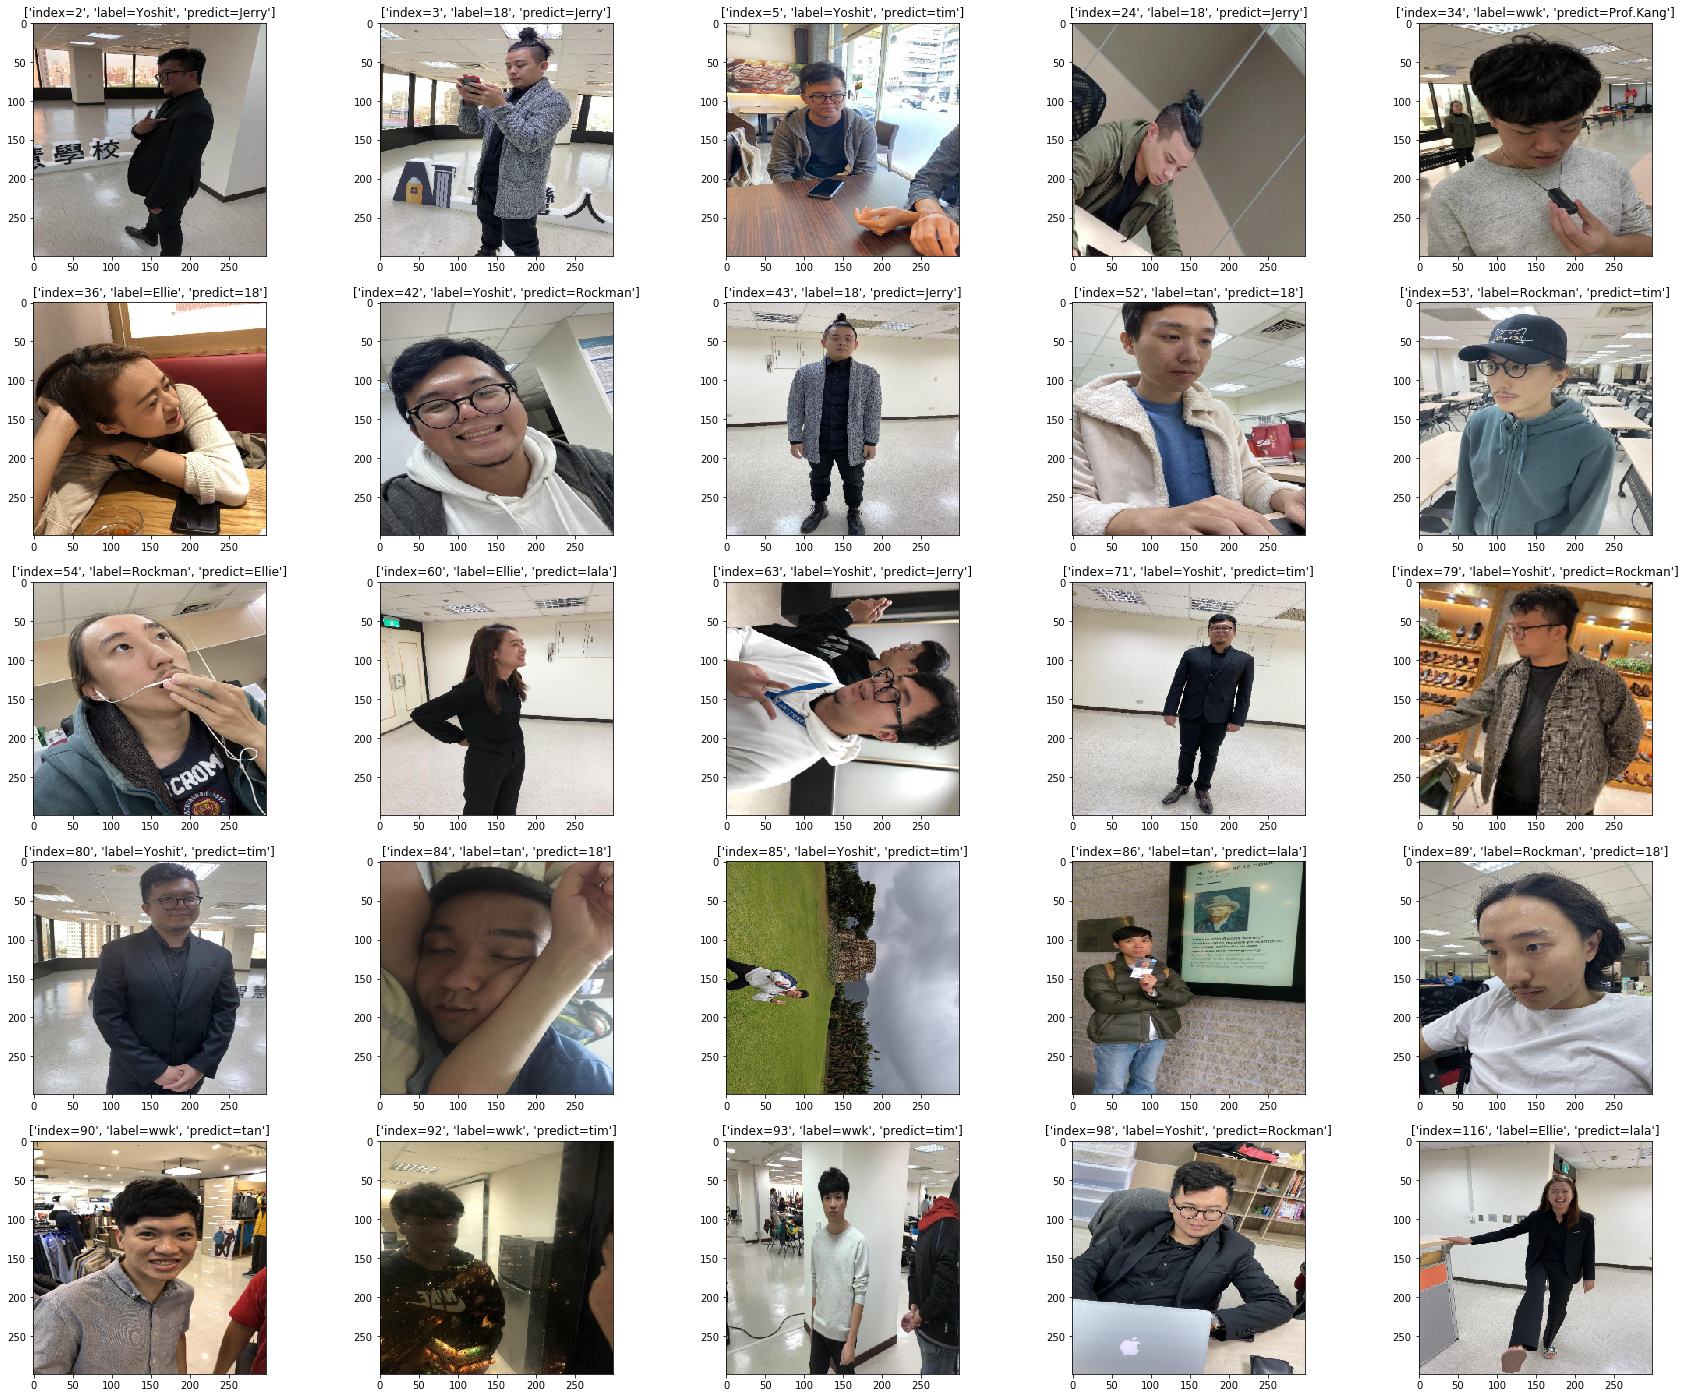

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(len(wrongindex)) :
    plt.subplot(int(len(wrongindex)/5)+1 , 5, i+1 )
    plt.imshow(X_valid[wrongindex[i]])   
    plt.gca().set_title(["index=" +str(wrongindex[i]),"label=" +str(df_wrong['label_1'].iloc[i]),"predict=" +str(df_wrong['predict_1'].iloc[i])])      

In [47]:
int(len(wrongindex)/5)+1

6

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 216x216 with 0 Axes>

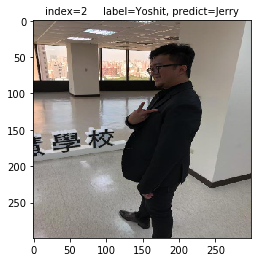

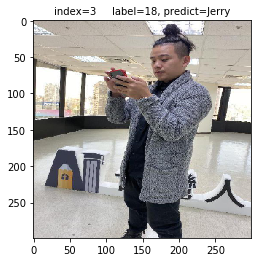

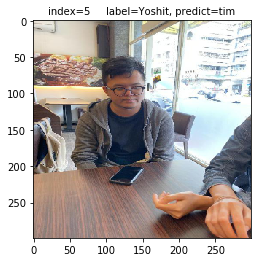

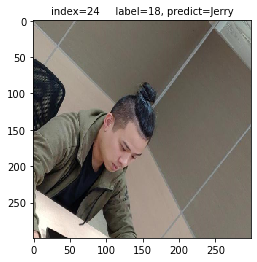

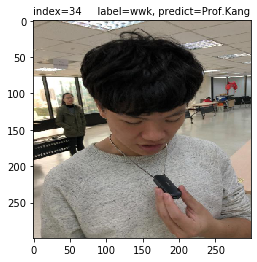

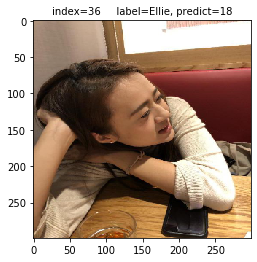

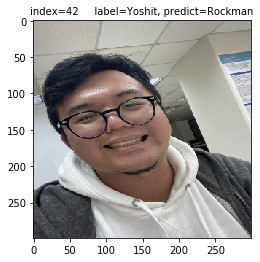

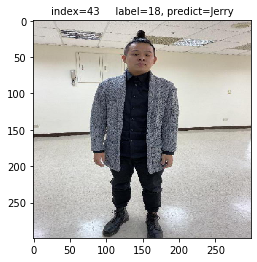

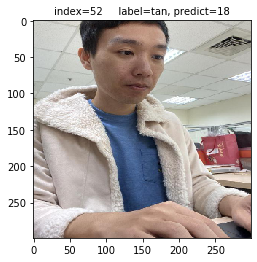

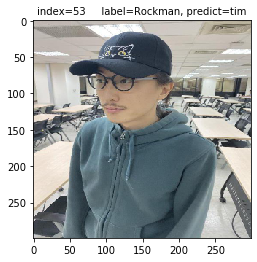

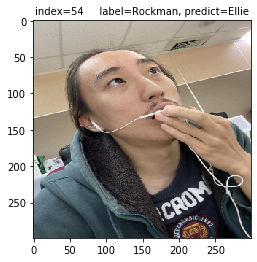

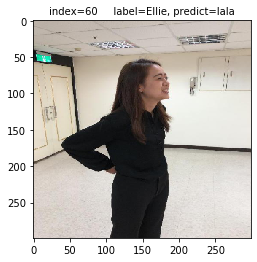

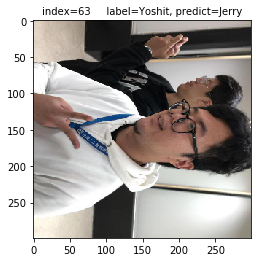

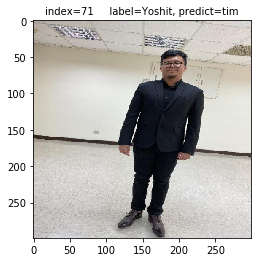

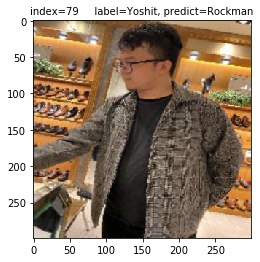

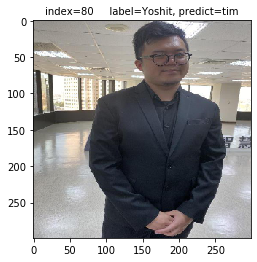

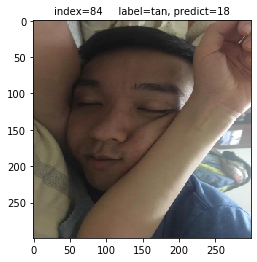

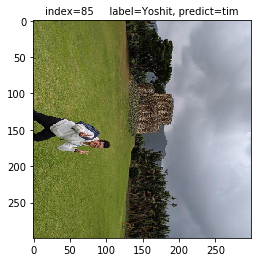

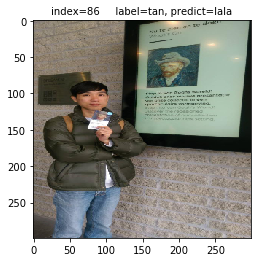

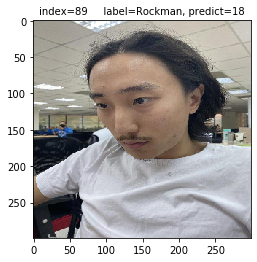

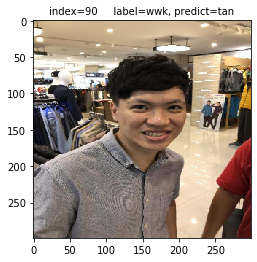

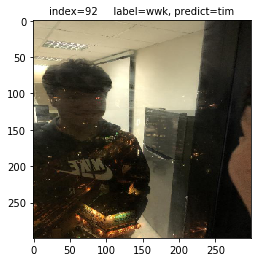

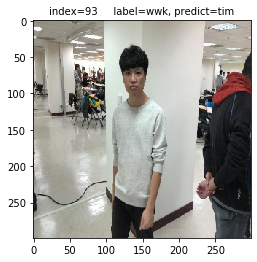

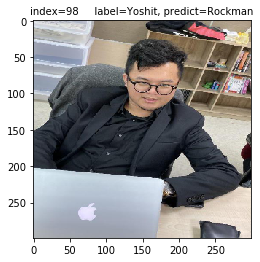

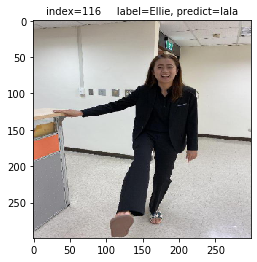

In [33]:
import matplotlib.pyplot as plt
fig = plt.gcf()

for i in range(len(wrongindex)) :
    plt.figure()
    plt.subplot()
    
    fig.set_size_inches(3, 3)
    ax = plt.axes()
    plt.imshow(X_valid[wrongindex[i]])
   
    title ="index=" +str(wrongindex[i])
    ax.set_title(title,fontsize=10)       
    title+="     label=" +str(df_wrong['label_1'].iloc[i])
    ax.set_title(title,fontsize=10)
    title+=", predict=" +str(df_wrong['predict_1'].iloc[i])
    ax.set_title(title,fontsize=10) 

In [34]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict    18  Ellie  Jerry  Prof.Kang  Rockman  Yoshit  lala  tan  tim  wwk
label                                                                       
18         12      0      3          0        0       0     0    0    0    0
Ellie       1      9      0          0        0       0     2    0    0    0
Jerry       0      0     11          0        0       0     0    0    0    0
Prof.Kang   0      0      0          8        0       0     0    0    0    0
Rockman     1      1      0          0       15       0     0    0    1    0
Yoshit      0      0      2          0        3       4     0    0    4    0
lala        0      0      0          0        0       0    10    0    0    0
tan         2      0      0          0        0       0     1   14    0    0
tim         0      0      0          0        0       0     0    0    4    0
wwk         0      0      0          1        0       0     0    1    2    6

In [35]:
mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}

Text(91.68, 0.5, 'label')

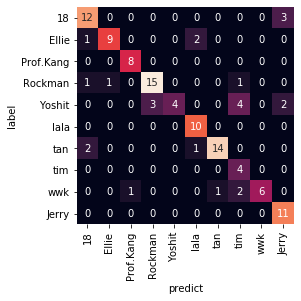

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_valid_1 , prediction_X_valid)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=mapping , yticklabels=mapping)
plt.xlabel('predict')
plt.ylabel('label')

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_1 , prediction_X_valid , target_names=mapping))

              precision    recall  f1-score   support

          18       0.75      0.80      0.77        15
       Ellie       0.90      0.75      0.82        12
   Prof.Kang       0.89      1.00      0.94         8
     Rockman       0.83      0.83      0.83        18
      Yoshit       1.00      0.31      0.47        13
        lala       0.77      1.00      0.87        10
         tan       0.93      0.82      0.87        17
         tim       0.36      1.00      0.53         4
         wwk       1.00      0.60      0.75        10
       Jerry       0.69      1.00      0.81        11

    accuracy                           0.79       118
   macro avg       0.81      0.81      0.77       118
weighted avg       0.85      0.79      0.78       118



# 預測 Test Data

In [38]:
img_paths = glob.glob('/home/jovyan/Midterm_DL/testset/*.jpg')
images = []
img_sizes = []
ids = []
for img_path in img_paths:
    ids.append(img_path.split("/")[-1].split(".")[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)

    images.append(img)

images_1 = np.array(images)


In [39]:
x_Test4D = images_1.reshape(images_1.shape[0],299,299,3).astype('float32') 

In [40]:
x_Test4D_normalize = x_Test4D/255

In [41]:
y_test_pred_prob = model.predict(x_Test4D_normalize)
prediction = y_test_pred_prob.argmax(axis=-1)

In [42]:
prediction[:10]

array([5, 5, 2, 9, 3, 8, 7, 3, 8, 6])

# Summit to Kaggle

In [43]:
submit = pd.read_csv("/home/jovyan/Midterm_DL/sample_submition.csv")

In [44]:
import pandas as pd
submit = pd.DataFrame({"id":ids, "class":prediction})

In [45]:
print(submit)

              id  class
0       IMG_5922      5
1       IMG_4066      5
2       IMG_1194      2
3    S__20275217      9
4       IMG_7365      3
..           ...    ...
127     IMG_0082      8
128     IMG_4833      4
129     IMG_0042      5
130     IMG_8804      3
131     IMG_7282      2

[132 rows x 2 columns]


In [46]:
submit.to_csv('Xception.csv', index = False)